In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
import os
import warnings

warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Masking
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

2023-01-16 16:01:49.077863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [4]:
import tensorboard
tensorboard.__version__

'2.10.0'

In [5]:
from tensorboard.plugins.hparams import api as hp

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
tf.keras.backend.clear_session()

In [8]:
data_dir = './data/'

In [9]:
master_country_code = 'USA'
master_country_name = 'United States'

In [10]:
world_area = 'Northern Hemisphere'  # World, Tropics, Southern Hemisphere

#
# Global warming: monthly temperature anomaly
# The combined land-surface air and sea-surface water temperature anomaly is given as the deviation from the 1951 - 1980 mean.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Temperature+anomaly&Long-run+series%3F=false
#

#
# Global warming: monthly sea surface temperature anomaly
# This is measured at a nominal depth of 20cm, and given relative to the average temperature from the period of 1961 - 1990.
# Source: https://ourworldindata.org/explorers/climate-change?facet=none&country=~OWID_WRL&Metric=Sea+surface+temperature+anomaly&Long-run+series%3F=false
#

df1 = pd.read_csv(data_dir + 'climate-change-air-new.csv', low_memory=False)
df1.drop(df1[df1.Entity != world_area].index, inplace=True)
df1.drop(columns=['Code', 'Entity'], inplace=True)
df1.rename(columns={'temperature_anomaly': world_area + '_temperature_anomaly'}, inplace=True)

df2 = pd.read_csv(data_dir + 'climate-change-water-new.csv', low_memory=False)
df2.drop(df2[df2.Entity != world_area].index, inplace=True)
df2.drop(columns=['Code', 'Entity'], inplace=True)
df2.rename(columns={'monthly_sea_surface_temperature_anomaly': world_area + '_sea_temperature_anomaly'}, inplace=True)

df = df1.merge(df2, on="Day", how = 'inner')
print("df.shape:")
print(df.shape)
df.head()

df.shape:
(1704, 3)


,Day,Northern Hemisphere_temperature_anomaly,Northern Hemisphere_sea_temperature_anomaly
0,1880-01-15,-0.35,-0.1281
1,1880-02-15,-0.51,-0.2394
2,1880-03-15,-0.23,0.0104
3,1880-04-15,-0.30,0.0088
4,1880-05-15,-0.06,-0.3421


In [11]:
df.tail()

,Day,Northern Hemisphere_temperature_anomaly,Northern Hemisphere_sea_temperature_anomaly
1699,2021-08-15,1.02,0.9257
1700,2021-09-15,1.05,1.0050
1701,2021-10-15,1.31,0.9012
1702,2021-11-15,1.30,0.8194
1703,2021-12-15,1.14,0.7203


In [12]:
orig_x_axis = df['Day'].copy(deep=True)

# The label for the predicted value - needs to be one unit bigger than what is shown in previous cell
future_x_axis = orig_x_axis.append(pd.Series(['2022-01-15']))

In [13]:
# Save main dataframe for use at the end of notebook - do a deep copy here
master_df = pd.DataFrame(df).copy(deep=True)

#
# Drop what's needed for the initial models which only uses one data column
# It is safe to drop dates (Day column) since they are all evenly spaced
#
df.drop(columns=['Day', world_area + '_sea_temperature_anomaly'], inplace=True)

# To keep dates must use the following (and adjust rest of code)
#df['Day'] =  pd.to_numeric(pd.to_datetime(df['Day'], format='%Y-%m-%d'))

df.head()

,Northern Hemisphere_temperature_anomaly
0,-0.35
1,-0.51
2,-0.23
3,-0.30
4,-0.06


In [14]:
df.tail()

,Northern Hemisphere_temperature_anomaly
1699,1.02
1700,1.05
1701,1.31
1702,1.30
1703,1.14


<br>
<br>
<br>

# **Create Main Climate Change Dataframe**
### Using all dataset csv files

In [15]:
#
# Apply method for each dataset's dataframe
#
def update_master_df(row):
   
    global df_main
    
    if row['Country Code'] != master_country_code:
        return
    
    #country = row['Country Code']
    code = row['Indicator Code']
    
    d = []
    
    for y in range(1960, 2021, 1):
        if str(y) in row:
            d.append(row[str(y)])
        else:
            d.append(float("NaN"))
    
    df_main[code] = d

      

file_names = [
    'API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_3053855.csv',     # Access to electricity (% of population) EG.ELC.ACCS.ZS
    'API_AG.LND.AGRI.ZS_DS2_en_csv_v2_3052884.csv',     # Agricultural land (% of land area) AG.LND.AGRI.ZS
    'API_AG.LND.ARBL.ZS_DS2_en_csv_v2_3054826.csv',     # Arable land (% of land area) AG.LND.ARBL.ZS
    'API_EN.ATM.CO2E.PC_DS2_en_csv_v2_3053008.csv',     # CO2 emissions (metric tons per capita) EN.ATM.CO2E.PC
    'API_AG.YLD.CREL.KG_DS2_en_csv_v2_3053734.csv',     # Cereal yield (kg per hectare) AG.YLD.CREL.KG
    'API_EG.USE.ELEC.KH.PC_DS2_en_csv_v2_3052822.csv',  # Electric power consumption (kWh per capita) EG.USE.ELEC.KH.PC
    'API_AG.LND.FRST.ZS_DS2_en_csv_v2_3052585.csv',     # Forest area (% of land area) AG.LND.FRST.ZS
    'API_AG.LND.EL5M.ZS_DS2_en_csv_v2_3057029.csv',     # Land area where elevation is below 5 meters (% of total land area) AG.LND.EL5M.ZS
    'API_SH.DYN.MORT_DS2_en_csv_v2_3058030.csv',        # Mortality rate, under-5 (per 1,000 live births) SH.DYN.MORT
    'API_SP.POP.GROW_DS2_en_csv_v2_3052790.csv',        # Population growth (annual %) SP.POP.GROW
    'API_EN.POP.EL5M.ZS_DS2_en_csv_v2_3057452.csv',     # Population living in areas where elevation is below 5 meters (% of total population) EN.POP.EL5M.ZS
    'API_SI.POV.DDAY_DS2_en_csv_v2_3055766.csv',        # Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population) SI.POV.DDAY
    'API_SE.PRM.CMPT.ZS_DS2_en_csv_v2_3053767.csv',     # Primary completion rate, total (% of relevant age group) SE.PRM.CMPT.ZS
    'API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_3053509.csv',     # Renewable energy consumption (% of total final energy consumption) EG.FEC.RNEW.ZS
    'API_SP.URB.TOTL_DS2_en_csv_v2_3058363.csv',        # Urban population SP.URB.TOTL
    'API_NV.AGR.TOTL.ZS_DS2_en_csv_v2_3052981.csv',     # Agriculture, forestry, and fishing, value added (% of GDP) NV.AGR.TOTL.ZS
    'API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3052647.csv',     # CO2 emissions (kt) EN.ATM.CO2E.KT
    'API_EG.USE.PCAP.KG.OE_DS2_en_csv_v2_3052915.csv',  # Energy use (kg of oil equivalent per capita) EG.USE.PCAP.KG.OE
    'API_AG.LND.FRST.K2_DS2_en_csv_v2_3054052.csv',     # Forest area (sq. km) AG.LND.FRST.K2
    'API_EN.ATM.METH.KT.CE_DS2_en_csv_v2_3052859.csv',  # Methane emissions (kt of CO2 equivalent) EN.ATM.METH.KT.CE
    'API_EN.ATM.NOXE.KT.CE_DS2_en_csv_v2_3054894.csv',  # Nitrous oxide emissions (thousand metric tons of CO2 equivalent) EN.ATM.NOXE.KT.CE
    'API_EN.URB.MCTY.TL.ZS_DS2_en_csv_v2_3053950.csv',  # Population in urban agglomerations of more than 1 million (% of total population) EN.URB.MCTY.TL.ZS
    'API_SP.POP.TOTL_DS2_en_csv_v2_3052518.csv',        # Population, total SP.POP.TOTL
    'API_SH.STA.MALN.ZS_DS2_en_csv_v2_3058087.csv',     # Prevalence of underweight, weight for age (% of children under 5) SH.STA.MALN.ZS
    'API_EG.ELC.RNEW.ZS_DS2_en_csv_v2_3054878.csv',     # Renewable electricity output (% of total electricity output) EG.ELC.RNEW.ZS
    'API_SE.ENR.PRSC.FM.ZS_DS2_en_csv_v2_3057870.csv',  # School enrollment, primary and secondary (gross), gender parity index (GPI) SE.ENR.PRSC.FM.ZS
    'API_EN.ATM.GHGT.KT.CE_DS2_en_csv_v2_3052850.csv',  # Total greenhouse gas emissions (kt of CO2 equivalent) EN.ATM.GHGT.KT.CE
    'API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_3053985.csv'   # Urban population (% of total population) SP.URB.TOTL.IN.ZS
]


#
# Main dataframe to work off of
#

df_main = pd.DataFrame(columns=['year'])
df_main['year'] = [
    1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
    1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
    1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
    1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
    2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
    2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
    2020
]


#
# Loop through each dataset and add it to the main dataframe
#
c = 0
df_collection = {}
for f in file_names:
    _df = pd.read_csv(data_dir + f)
    _df.drop(columns=['Country Name', 'Indicator Name'], inplace=True)
    _df.drop(_df.columns[_df.columns.str.contains('unnamed', case = False)], axis = 1, inplace = True)
    df_collection[c] = _df
    _df.apply(update_master_df, axis=1)             
    c += 1

#pd.set_option("display.max_rows", None, "display.max_columns", None)
df_main.head(65)

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1960,NaN,NaN,NaN,15.999779,NaN,4049.786629,NaN,NaN,30.1,...,NaN,NaN,NaN,38.732606,180671000.0,NaN,NaN,NaN,NaN,69.996
1,1961,NaN,48.860242,19.721671,15.681256,2522.3,4182.175501,NaN,NaN,29.5,...,NaN,NaN,NaN,38.846570,183691000.0,NaN,NaN,NaN,NaN,70.377
2,1962,NaN,48.476137,19.335711,16.013937,2683.1,4433.606021,NaN,NaN,28.9,...,NaN,NaN,NaN,39.013264,186538000.0,NaN,NaN,NaN,NaN,70.757
3,1963,NaN,48.197940,19.606375,16.482762,2800.6,4690.486256,NaN,NaN,28.3,...,NaN,NaN,NaN,39.224184,189242000.0,NaN,NaN,NaN,NaN,71.134
4,1964,NaN,47.932516,19.430809,16.968119,2639.3,4970.446456,NaN,NaN,27.7,...,NaN,NaN,NaN,39.461981,191889000.0,NaN,NaN,NaN,NaN,71.508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2016,100.0,44.303705,17.184190,15.131747,8614.3,NaN,33.899723,NaN,6.7,...,3100950.0,609200.0,248510.0,45.713256,323071755.0,1.4,NaN,0.99626,5907270.0,81.862
57,2017,100.0,44.363367,17.243857,14.805882,8781.1,NaN,33.866926,NaN,6.7,...,3097950.0,614500.0,249290.0,45.980612,325122128.0,NaN,NaN,0.99363,5842800.0,82.058
58,2018,100.0,44.363367,17.243857,15.240875,8691.6,NaN,33.866926,NaN,6.6,...,3097950.0,622590.0,250060.0,46.304526,326838199.0,0.4,NaN,0.99470,6023620.0,82.256
59,2019,100.0,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,6.5,...,3097950.0,NaN,NaN,46.473733,328329953.0,NaN,NaN,NaN,NaN,82.459


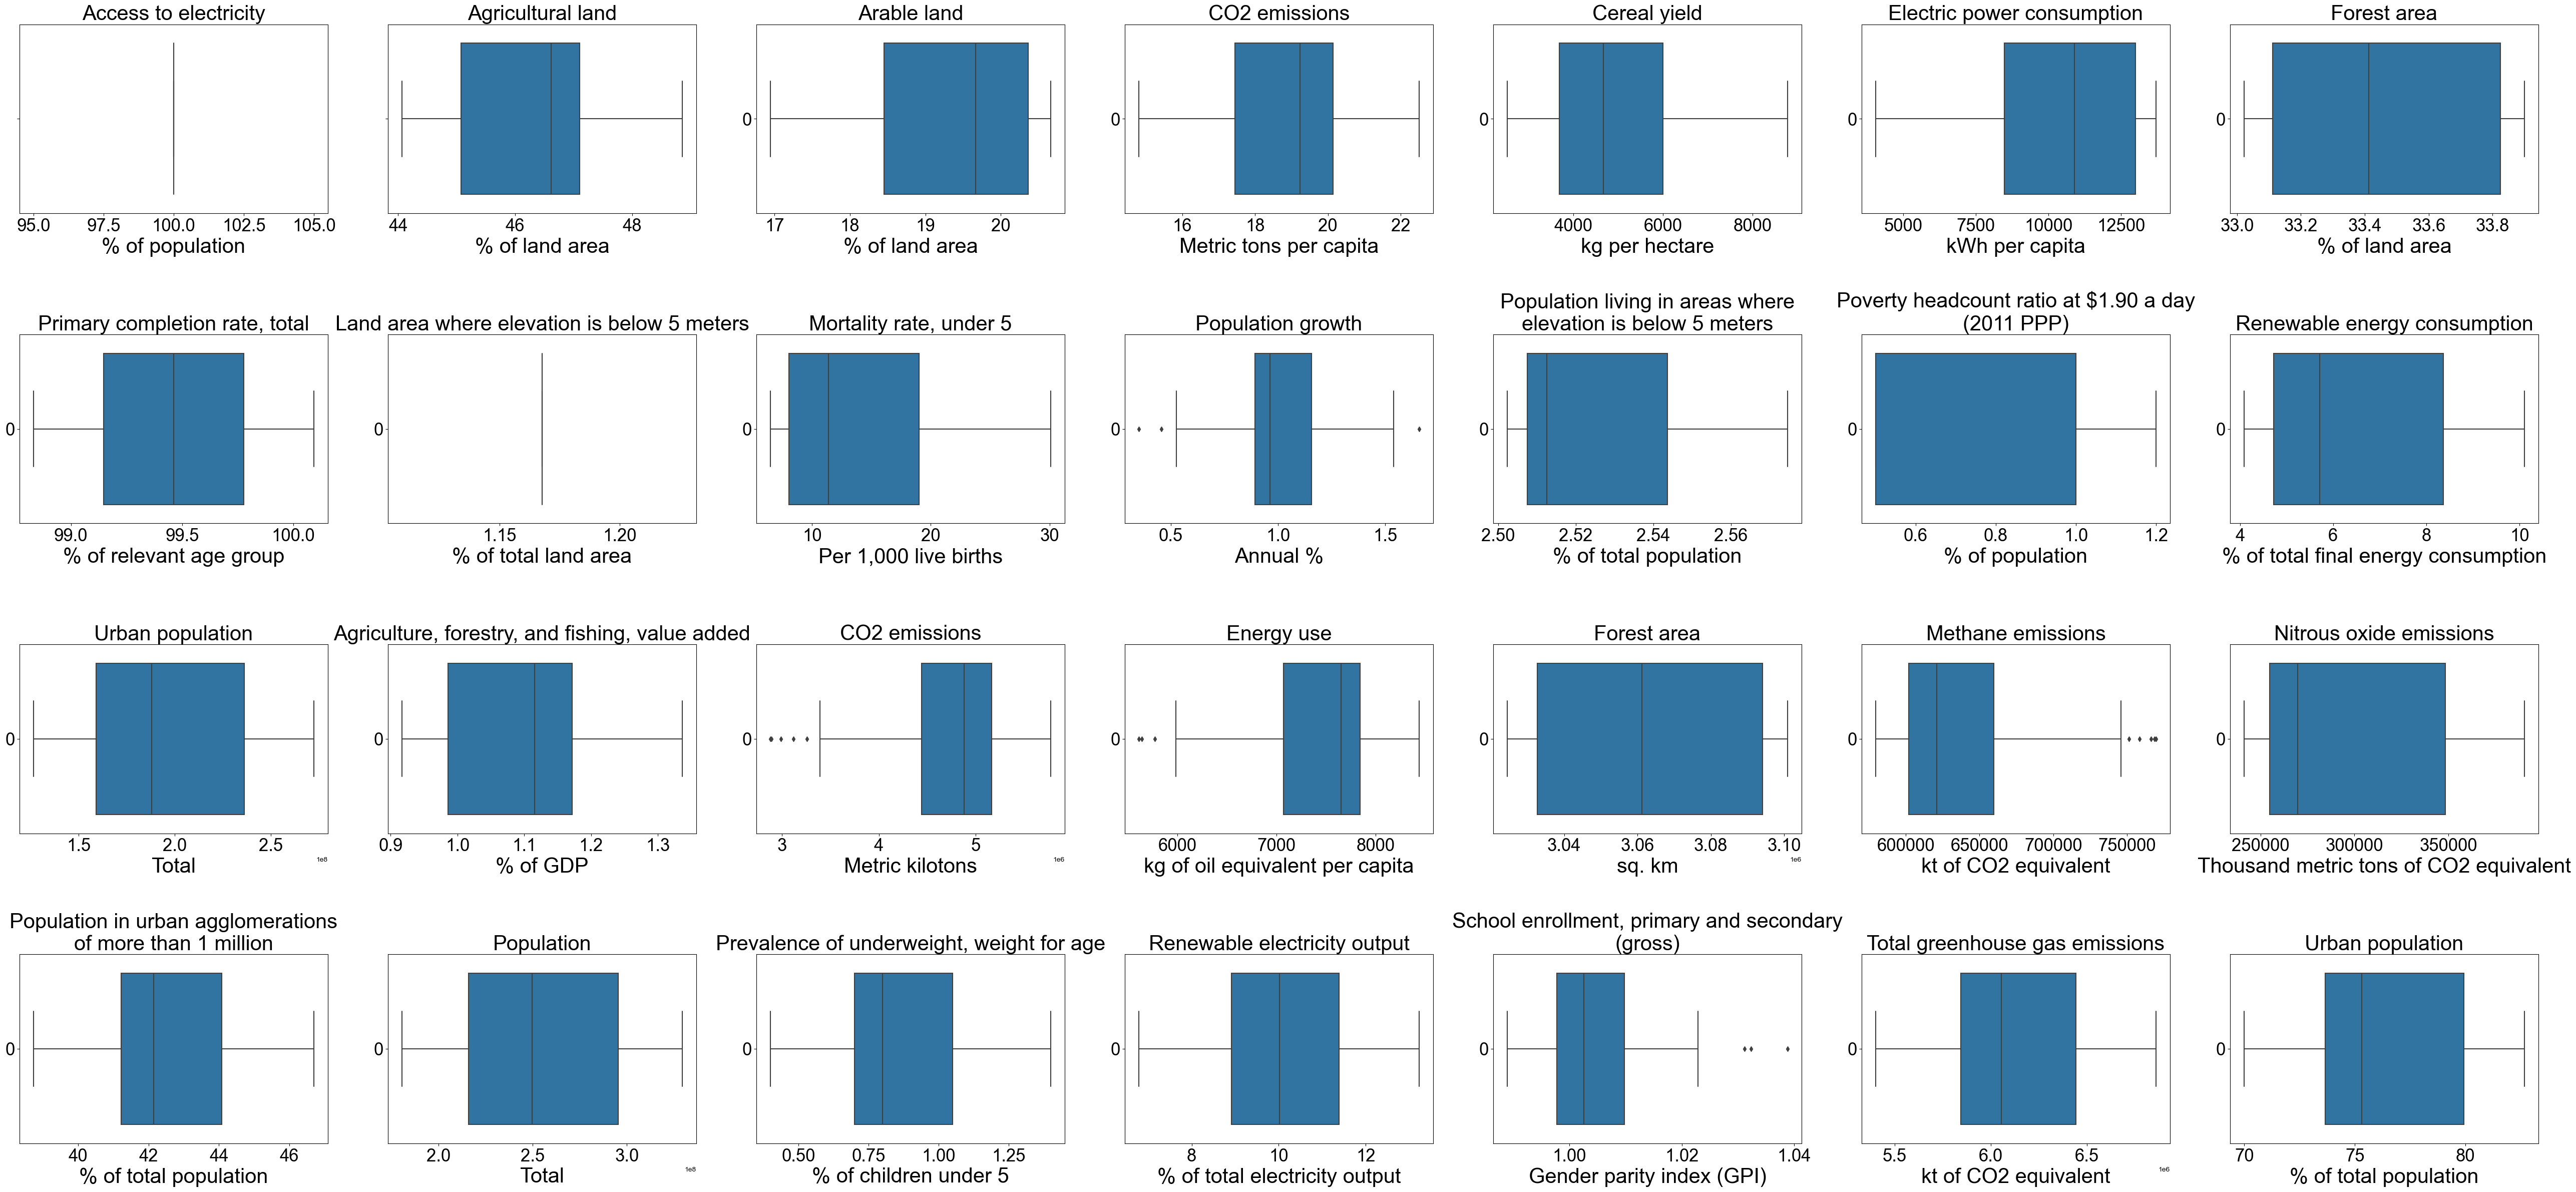

In [16]:
#
# Box Plots of each feature
#


f, axs = plt.subplots(4, 7, figsize=(52, 25), constrained_layout=True);

sns.set_style("whitegrid", {'axes.grid' : False});

# Row 1
sns.boxplot(x=df_main['EG.ELC.ACCS.ZS'], ax=axs[0,0], orient='horizontal').set_xlabel('% of population', fontsize=30) #, ylabel='')
axs[0,0].set_title('Access to electricity', fontsize=30)
axs[0,0].tick_params(labelsize=25)

sns.boxplot(x=df_main['AG.LND.AGRI.ZS'], ax=axs[0,1], orient='horizontal').set_xlabel('% of land area', fontsize=30)
axs[0,1].set_title('Agricultural land', fontsize=30)
axs[0,1].tick_params(labelsize=25)

sns.boxplot(df_main['AG.LND.ARBL.ZS'], ax=axs[0,2], orient='horizontal').set_xlabel('% of land area', fontsize=30)
axs[0,2].set_title('Arable land', fontsize=30)
axs[0,2].tick_params(labelsize=25)

sns.boxplot(df_main['EN.ATM.CO2E.PC'], ax=axs[0,3], orient='horizontal').set_xlabel('Metric tons per capita', fontsize=30)
axs[0,3].set_title('CO2 emissions', fontsize=30)
axs[0,3].tick_params(labelsize=25)

sns.boxplot(df_main['AG.YLD.CREL.KG'], ax=axs[0,4], orient='horizontal').set_xlabel('kg per hectare', fontsize=30)
axs[0,4].set_title('Cereal yield', fontsize=30)
axs[0,4].tick_params(labelsize=25)

sns.boxplot(df_main['EG.USE.ELEC.KH.PC'], ax=axs[0,5], orient='horizontal').set_xlabel('kWh per capita', fontsize=30)
axs[0,5].set_title('Electric power consumption', fontsize=30)
axs[0,5].tick_params(labelsize=25)

sns.boxplot(df_main['AG.LND.FRST.ZS'], ax=axs[0,6], orient='horizontal').set_xlabel('% of land area', fontsize=30)
axs[0,6].set_title('Forest area', fontsize=30)
axs[0,6].tick_params(labelsize=25)


# Row 2

sns.boxplot(df_main['SE.PRM.CMPT.ZS'], ax=axs[1,0], orient='horizontal').set_xlabel('% of relevant age group', fontsize=30)
axs[1,0].set_title('Primary completion rate, total', fontsize=30)
axs[1,0].tick_params(labelsize=25)

sns.boxplot(df_main['AG.LND.EL5M.ZS'], ax=axs[1,1], orient='horizontal').set_xlabel('% of total land area', fontsize=30)
axs[1,1].set_title('Land area where elevation is below 5 meters', fontsize=30)
axs[1,1].tick_params(labelsize=25)

sns.boxplot(df_main['SH.DYN.MORT'], ax=axs[1,2], orient='horizontal').set_xlabel('Per 1,000 live births', fontsize=30)
axs[1,2].set_title('Mortality rate, under 5', fontsize=30)
axs[1,2].tick_params(labelsize=25)

sns.boxplot(df_main['SP.POP.GROW'], ax=axs[1,3], orient='horizontal').set_xlabel('Annual %', fontsize=30)
axs[1,3].set_title('Population growth', fontsize=30)
axs[1,3].tick_params(labelsize=25)

sns.boxplot(df_main['EN.POP.EL5M.ZS'], ax=axs[1,4], orient='horizontal').set_xlabel('% of total population', fontsize=30)
axs[1,4].set_title('Population living in areas where\nelevation is below 5 meters', fontsize=30)
axs[1,4].tick_params(labelsize=25)

sns.boxplot(df_main['SI.POV.DDAY'], ax=axs[1,5], orient='horizontal').set_xlabel('% of population', fontsize=30)
axs[1,5].set_title('Poverty headcount ratio at $1.90 a day\n(2011 PPP)', fontsize=30)
axs[1,5].tick_params(labelsize=25)

sns.boxplot(df_main['EG.FEC.RNEW.ZS'], ax=axs[1,6], orient='horizontal').set_xlabel('% of total final energy consumption', fontsize=30)
axs[1,6].set_title('Renewable energy consumption', fontsize=30)
axs[1,6].tick_params(labelsize=25)



# Row 3

sns.boxplot(df_main['SP.URB.TOTL'], ax=axs[2,0], orient='horizontal').set_xlabel('Total', fontsize=30)
axs[2,0].set_title('Urban population', fontsize=30)
axs[2,0].tick_params(labelsize=25)

sns.boxplot(df_main['NV.AGR.TOTL.ZS'], ax=axs[2,1], orient='horizontal').set_xlabel('% of GDP', fontsize=30)
axs[2,1].set_title('Agriculture, forestry, and fishing, value added', fontsize=30)
axs[2,1].tick_params(labelsize=25)

sns.boxplot(df_main['EN.ATM.CO2E.KT'], ax=axs[2,2], orient='horizontal').set_xlabel('Metric kilotons', fontsize=30)
axs[2,2].set_title('CO2 emissions', fontsize=30)
axs[2,2].tick_params(labelsize=25)

sns.boxplot(df_main['EG.USE.PCAP.KG.OE'], ax=axs[2,3], orient='horizontal').set_xlabel('kg of oil equivalent per capita', fontsize=30)
axs[2,3].set_title('Energy use', fontsize=30)
axs[2,3].tick_params(labelsize=25)

sns.boxplot(df_main['AG.LND.FRST.K2'], ax=axs[2,4], orient='horizontal').set_xlabel('sq. km', fontsize=30)
axs[2,4].set_title('Forest area', fontsize=30)
axs[2,4].tick_params(labelsize=25)

sns.boxplot(df_main['EN.ATM.METH.KT.CE'], ax=axs[2,5], orient='horizontal').set_xlabel('kt of CO2 equivalent', fontsize=30)
axs[2,5].set_title('Methane emissions', fontsize=30)
axs[2,5].tick_params(labelsize=25)

sns.boxplot(df_main['EN.ATM.NOXE.KT.CE'], ax=axs[2,6], orient='horizontal').set_xlabel('Thousand metric tons of CO2 equivalent', fontsize=30)
axs[2,6].set_title('Nitrous oxide emissions', fontsize=30)
axs[2,6].tick_params(labelsize=25)



# Row 4

sns.boxplot(df_main['EN.URB.MCTY.TL.ZS'], ax=axs[3,0], orient='horizontal').set_xlabel('% of total population', fontsize=30)
axs[3,0].set_title('Population in urban agglomerations\nof more than 1 million', fontsize=30)
axs[3,0].tick_params(labelsize=25)

sns.boxplot(df_main['SP.POP.TOTL'], ax=axs[3,1], orient='horizontal').set_xlabel('Total', fontsize=30)
axs[3,1].set_title('Population', fontsize=30)
axs[3,1].tick_params(labelsize=25)

sns.boxplot(df_main['SH.STA.MALN.ZS'], ax=axs[3,2], orient='horizontal').set_xlabel('% of children under 5', fontsize=30)
axs[3,2].set_title('Prevalence of underweight, weight for age', fontsize=30)
axs[3,2].tick_params(labelsize=25)

sns.boxplot(df_main['EG.ELC.RNEW.ZS'], ax=axs[3,3], orient='horizontal').set_xlabel('% of total electricity output', fontsize=30)
axs[3,3].set_title('Renewable electricity output', fontsize=30)
axs[3,3].tick_params(labelsize=25)

sns.boxplot(df_main['SE.ENR.PRSC.FM.ZS'], ax=axs[3,4], orient='horizontal').set_xlabel('Gender parity index (GPI)', fontsize=30)
axs[3,4].set_title('School enrollment, primary and secondary\n(gross)', fontsize=30)
axs[3,4].tick_params(labelsize=25)

sns.boxplot(df_main['EN.ATM.GHGT.KT.CE'], ax=axs[3,5], orient='horizontal').set_xlabel('kt of CO2 equivalent', fontsize=30)
axs[3,5].set_title('Total greenhouse gas emissions', fontsize=30)
axs[3,5].tick_params(labelsize=25)

sns.boxplot(df_main['SP.URB.TOTL.IN.ZS'], ax=axs[3,6], orient='horizontal').set_xlabel('% of total population', fontsize=30)
axs[3,6].set_title('Urban population', fontsize=30)
axs[3,6].tick_params(labelsize=25)



#f.delaxes(axs[4][4])
#f.delaxes(axs[4][5])

f.tight_layout(pad=5.0);
#f.suptitle('Box Plots') # or plt.suptitle('Box Plots')

plt.savefig("./images/box-plots-horizontal.png")

plt.show();

In [17]:
#
# Add the beginning years (1880 to 1959) for which there are temperature data but no data for the coarse datasets
#

for i in range(1959, 1879, -1):
    df_main.loc[-1] = [i, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
    df_main.index = df_main.index + 1
    df_main = df_main.sort_index()

In [18]:
#
# Make 12 copies for each row. The termperature dataset comes in 12 data points per year and the other datasets provide one data point per year
# Just copy the row 12 times as a best approximation
#

df_main = df_main.loc[df_main.index.repeat(12)]
df_main = df_main.sort_index()
df_main.reset_index(drop=True, inplace=True)

In [19]:
#
# Show that there are 12 rows for 1880
#

df_main.head(13)

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_main.tail(13)

,year,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
1679,2019.0,100.0,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,6.5,...,3097950.0,NaN,NaN,46.473733,328329953.0,NaN,NaN,NaN,NaN,82.459
1680,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1681,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1682,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1683,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1684,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1685,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1686,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1687,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1688,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664


In [21]:
#
# Convert all 'year' values from 1980.0 to '1980-01-15', etc
# Use the index mod by 12 to determine what month it should be. The temperature day is always set to 15 in the temperature dataset
#

df_main['year'] = df_main['year'].astype('int64')

def fix_dates(row):
    idx = int(row.name)
    month = (idx % 12) + 1
    month = f'{month:02d}'
    row['year'] = str(int(row['year'])) + '-' + str(month) + '-15'
    # print(row.name)
    return row

new_df = df_main.apply(fix_dates, axis=1)

# Rename year column to Day (to join on with other dataframe)
new_df.rename(columns={'year': 'Day'}, inplace=True)

In [22]:
new_df.head(13)

,Day,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1880-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1880-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1880-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1880-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1880-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1880-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
new_df.tail(13)

,Day,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
1679,2019-12-15,100.0,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,6.5,...,3097950.0,NaN,NaN,46.473733,328329953.0,NaN,NaN,NaN,NaN,82.459
1680,2020-01-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1681,2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1682,2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1683,2020-04-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1684,2020-05-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1685,2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1686,2020-07-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1687,2020-08-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1688,2020-09-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664


In [24]:
#
# Fill in the missing rows at the end where the datasets do not have the same length as the temperature datasets
# (Temperature goes up to Nov 2021, other datasets end at Dec 2020)
#

data_values=new_df.tail(1).values

data_values[0][0] = '2021-01-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-02-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-03-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-04-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-05-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-06-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-07-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-08-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-09-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-10-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-11-15'
new_df.loc[len(new_df.index)] = data_values[0]
data_values[0][0] = '2021-12-15'
new_df.loc[len(new_df.index)] = data_values[0]

In [25]:
new_df.tail(12)

,Day,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,SH.DYN.MORT,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
1692,2021-01-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1693,2021-02-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1694,2021-03-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1695,2021-04-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1696,2021-05-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1697,2021-06-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1698,2021-07-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1699,2021-08-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1700,2021-09-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1701,2021-10-15,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,NaN,NaN,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664


In [26]:
# These numbers should be equal (the same as the original dataframe in length)

print("These two datafame lengths should now be equal so they can be joined:")
print(len(new_df))
print(len(master_df))

These two datafame lengths should now be equal so they can be joined:
1704
1704


In [27]:
#
# Create the final dataframe by merging the original saved at the beginning and the newly dataframe just created
#

final_df = pd.merge(master_df, new_df, on="Day")
final_df

,Day,Northern Hemisphere_temperature_anomaly,Northern Hemisphere_sea_temperature_anomaly,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,1880-01-15,-0.35,-0.1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880-02-15,-0.51,-0.2394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1880-03-15,-0.23,0.0104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1880-04-15,-0.30,0.0088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1880-05-15,-0.06,-0.3421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2021-08-15,1.02,0.9257,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1700,2021-09-15,1.05,1.0050,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1701,2021-10-15,1.31,0.9012,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664
1702,2021-11-15,1.30,0.8194,NaN,NaN,NaN,NaN,NaN,NaN,33.866926,...,3097950.0,NaN,NaN,46.697115,329484123.0,NaN,NaN,NaN,NaN,82.664


## Correlation Matrices
#### Look at the correlation of the features to the target column: 'world_air_temperature_anomaly'

In [28]:
df_pearson = final_df.corr(method='pearson')
df_pearson

,Northern Hemisphere_temperature_anomaly,Northern Hemisphere_sea_temperature_anomaly,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
Northern Hemisphere_temperature_anomaly,1.000000,0.885770,NaN,-0.821289,-0.764367,-0.456758,0.840554,0.723186,0.743145,NaN,...,0.749166,0.204359,-0.703986,0.847195,0.866296,0.065306,0.138444,-0.414559,0.474432,0.858352
Northern Hemisphere_sea_temperature_anomaly,0.885770,1.000000,NaN,-0.850131,-0.764659,-0.454123,0.868606,0.767735,0.729313,NaN,...,0.733661,0.293959,-0.741503,0.867229,0.890194,0.080219,0.218938,-0.461892,0.520362,0.880168
EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AG.LND.AGRI.ZS,-0.821289,-0.850131,NaN,1.000000,0.799601,0.321409,-0.932105,-0.902325,-0.895431,NaN,...,-0.899793,-0.225542,0.816928,-0.974085,-0.978333,0.130038,-0.265084,0.557863,-0.592451,-0.985830
AG.LND.ARBL.ZS,-0.764367,-0.764659,NaN,0.799601,1.000000,0.704217,-0.803209,-0.475607,-0.971530,NaN,...,-0.976205,-0.054404,0.776040,-0.775927,-0.798775,0.201504,-0.274950,0.495847,-0.447640,-0.820489
EN.ATM.CO2E.PC,-0.456758,-0.454123,NaN,0.321409,0.704217,1.000000,-0.451347,0.132824,-0.902898,NaN,...,-0.891782,-0.051908,0.603588,-0.275146,-0.344185,0.279883,-0.716348,0.317061,0.003150,-0.312953
AG.YLD.CREL.KG,0.840554,0.868606,NaN,-0.932105,-0.803209,-0.451347,1.000000,0.884171,0.881927,NaN,...,0.886574,0.158084,-0.757709,0.958078,0.960995,0.104578,0.149793,-0.458602,0.449591,0.957615
EG.USE.ELEC.KH.PC,0.723186,0.767735,NaN,-0.902325,-0.475607,0.132824,0.884171,1.000000,0.470487,NaN,...,0.496746,0.610775,-0.785727,0.923778,0.935737,0.281054,-0.442450,-0.675997,0.840777,0.912875
AG.LND.FRST.ZS,0.743145,0.729313,NaN,-0.895431,-0.971530,-0.902898,0.881927,0.470487,1.000000,NaN,...,0.999309,-0.892936,-0.707671,0.919846,0.966618,-0.210271,0.430354,-0.061619,-0.348665,0.931665
AG.LND.EL5M.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#df_kendall = final_df.corr(method='kendall')
#df_kendall

In [30]:
#df_spearman = final_df.corr(method='spearman')
#df_spearman

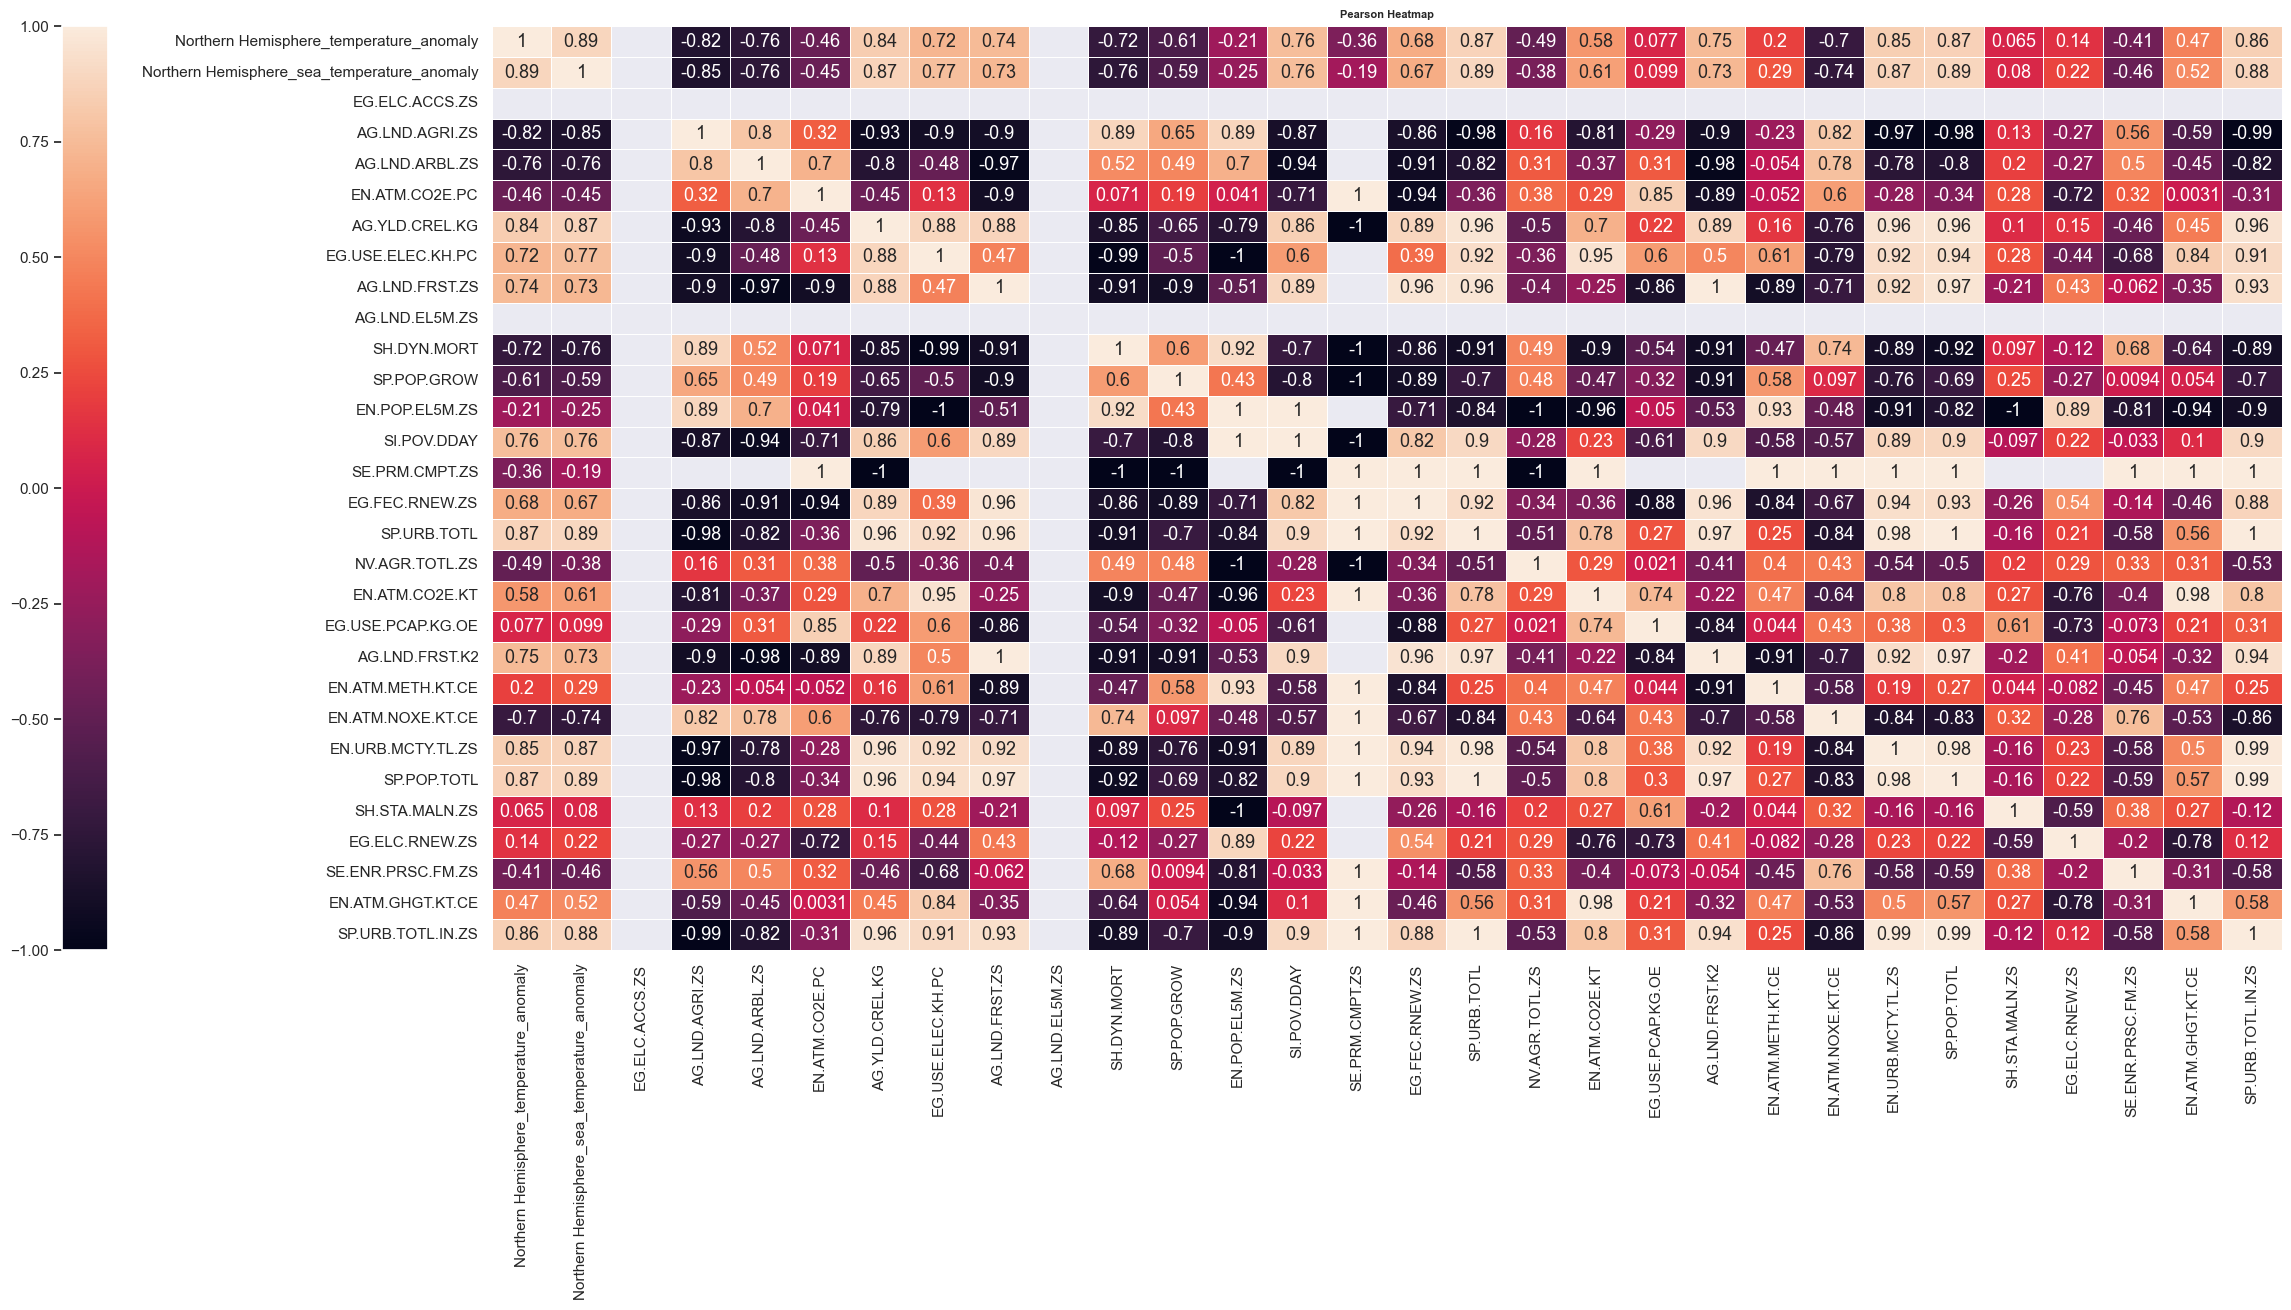

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

title1 = 'Pearson'
title_size = 8

sns.set(rc = {'figure.figsize':(33,12)})
fig, ax1 = plt.subplots(ncols=1)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(df_pearson, cmap="rocket", ax=ax1, cbar=False, linewidths=.5, annot=True, annot_kws={"fontsize": 13})
fig.colorbar(ax1.collections[0], ax=ax1, location="left", use_gridspec=False, pad=0.15)
#sns.heatmap(df_pearson2, cmap="rocket", ax=ax2, cbar=False, linewidths=.5, annot=True, annot_kws={"fontsize": 20})
#fig.colorbar(ax2.collections[0], ax=ax2, location="right", use_gridspec=False, pad=0.15)
#ax2.yaxis.tick_right()
#ax2.xaxis.tick_bottom()
#ax2.tick_params(axis='y', rotation=1)
ax1.set_title(title1 + " Heatmap", weight='bold', fontsize=title_size)
#ax2.set_title(title2 + " Heatmap", weight='bold', fontsize=title_size)
plt.show();

In [32]:
#
# Setup X-axis labels for plot and drop Day column so that MinMaxScaler can be used (remove string columns)
#
# NOTE: Call MinMaxScaler BEFORE fillna with -1 !!!
#

# Test to drop the beginning n rows to compare prediction results - currently OFF
#num_rows_to_drop = 960

orig_x_axis = final_df['Day'].copy(deep=True)

#orig_x_axis = orig_x_axis[num_rows_to_drop:]

# Add the future prediction's x-axis label 
future_x_axis = orig_x_axis.append(pd.Series(['2022-01-15']))
future_x_axis.reset_index(drop=True, inplace=True)

final_df.drop('Day', axis=1, inplace=True)

In [33]:
future_x_axis

0       1880-01-15
1       1880-02-15
2       1880-03-15
3       1880-04-15
4       1880-05-15
           ...    
1700    2021-09-15
1701    2021-10-15
1702    2021-11-15
1703    2021-12-15
1704    2022-01-15
Length: 1705, dtype: object

In [34]:
#
# Save orig feature column BEFORE MinMaxScalar so it can be easily plotted without inverse-scaling
#

orig_plot_data = final_df[world_area + '_temperature_anomaly'].copy(deep=True).values

In [35]:
#
# READY to scale the dataset!
#

#np.random.seed(7)
scaler = MinMaxScaler(feature_range=(0, 1))
final_df[final_df.columns] = scaler.fit_transform(final_df[final_df.columns])

#
# Create a new scaler that can be used for a ONE COLUMN numpy array
# The initial data was scaled by all columns so there are 31 values for min_, scale_, etc
# We only need the first values to descale the output values
#

# The first min_ and scale_ values from the original MinMaxScaler
new_scaler = MinMaxScaler()
new_scaler.min_, new_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

In [36]:
#
# Forward fill the end of each column to give some values for 2021 that are missing from the coarse datasets
# NOTE: Leaving this step out reduces the final 12 test values - best to keep it in if the data is missing
#

final_df.fillna(method='ffill', inplace=True)

# See if correlation changed after MinMaxScaler
#df_spearman = final_df.corr(method='spearman')
#df_spearman

In [37]:
#
# Fill in all NaN values with -1 so that these values can be masked during the model fit
#

final_df.fillna(value=-1, inplace=True)

In [38]:
#final_df.drop(index=final_df.index[:num_rows_to_drop], axis=0, inplace=True)
#final_df.head(961)

In [39]:
#
# Delete column 'world_sea_temperature_anomaly' ??? - Leave it in since it does have high correlation with the target
#

#final_df.drop(['world_sea_temperature_anomaly'], axis=1, inplace=True)

In [40]:
final_df.reset_index(drop=True, inplace=True)
final_df.head()

,Northern Hemisphere_temperature_anomaly,Northern Hemisphere_sea_temperature_anomaly,EG.ELC.ACCS.ZS,AG.LND.AGRI.ZS,AG.LND.ARBL.ZS,EN.ATM.CO2E.PC,AG.YLD.CREL.KG,EG.USE.ELEC.KH.PC,AG.LND.FRST.ZS,AG.LND.EL5M.ZS,...,AG.LND.FRST.K2,EN.ATM.METH.KT.CE,EN.ATM.NOXE.KT.CE,EN.URB.MCTY.TL.ZS,SP.POP.TOTL,SH.STA.MALN.ZS,EG.ELC.RNEW.ZS,SE.ENR.PRSC.FM.ZS,EN.ATM.GHGT.KT.CE,SP.URB.TOTL.IN.ZS
0,0.338150,0.334584,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.291908,0.277372,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.372832,0.405778,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.352601,0.404955,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.421965,0.224581,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [41]:
print("Final Columns:")
final_df.columns

Final Columns:


Index(['Northern Hemisphere_temperature_anomaly',
       'Northern Hemisphere_sea_temperature_anomaly', 'EG.ELC.ACCS.ZS',
       'AG.LND.AGRI.ZS', 'AG.LND.ARBL.ZS', 'EN.ATM.CO2E.PC', 'AG.YLD.CREL.KG',
       'EG.USE.ELEC.KH.PC', 'AG.LND.FRST.ZS', 'AG.LND.EL5M.ZS', 'SH.DYN.MORT',
       'SP.POP.GROW', 'EN.POP.EL5M.ZS', 'SI.POV.DDAY', 'SE.PRM.CMPT.ZS',
       'EG.FEC.RNEW.ZS', 'SP.URB.TOTL', 'NV.AGR.TOTL.ZS', 'EN.ATM.CO2E.KT',
       'EG.USE.PCAP.KG.OE', 'AG.LND.FRST.K2', 'EN.ATM.METH.KT.CE',
       'EN.ATM.NOXE.KT.CE', 'EN.URB.MCTY.TL.ZS', 'SP.POP.TOTL',
       'SH.STA.MALN.ZS', 'EG.ELC.RNEW.ZS', 'SE.ENR.PRSC.FM.ZS',
       'EN.ATM.GHGT.KT.CE', 'SP.URB.TOTL.IN.ZS'],
      dtype='object')

In [42]:
# There should be NO NaN values anywhere in the dataframe
# Non-Null Count should all be 1703

final_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Northern Hemisphere_temperature_anomaly      1704 non-null   float64
 1   Northern Hemisphere_sea_temperature_anomaly  1704 non-null   float64
 2   EG.ELC.ACCS.ZS                               1704 non-null   float64
 3   AG.LND.AGRI.ZS                               1704 non-null   float64
 4   AG.LND.ARBL.ZS                               1704 non-null   float64
 5   EN.ATM.CO2E.PC                               1704 non-null   float64
 6   AG.YLD.CREL.KG                               1704 non-null   float64
 7   EG.USE.ELEC.KH.PC                            1704 non-null   float64
 8   AG.LND.FRST.ZS                               1704 non-null   float64
 9   AG.LND.EL5M.ZS                               1704 non-null   float64
 10  

In [43]:
#
# Create a seperate Series for each of the dataframe's columns
#
col1 = final_df[world_area + '_temperature_anomaly'].values
col1 = col1.reshape((len(col1), 1))
col2 = final_df[world_area + '_sea_temperature_anomaly'].values
col2 = col2.reshape((len(col2), 1))

#col3 = final_df['EG.ELC.ACCS.ZS'].values  # Disabled for: USA, Japan, GBR, Germany, France, Italy, Australia
#col3 = col3.reshape((len(col3), 1))

col4 = final_df['AG.LND.AGRI.ZS'].values
col4 = col4.reshape((len(col4), 1))

col5 = final_df['AG.LND.ARBL.ZS'].values
col5 = col5.reshape((len(col5), 1))

col6 = final_df['EN.ATM.CO2E.PC'].values
col6 = col6.reshape((len(col6), 1))

col7 = final_df['AG.YLD.CREL.KG'].values
col7 = col7.reshape((len(col7), 1))

col8 = final_df['EG.USE.ELEC.KH.PC'].values
col8 = col8.reshape((len(col8), 1))

col9 = final_df['AG.LND.FRST.ZS'].values
col9 = col9.reshape((len(col9), 1))

#col10 = final_df['AG.LND.EL5M.ZS'].values  # Disabled for: India, Russia, China, USA, Japan, GBR, DEU, France, Italy, Australia
#col10 = col10.reshape((len(col10), 1))

col11 = final_df['SH.DYN.MORT'].values
col11 = col11.reshape((len(col11), 1))

col12 = final_df['SP.POP.GROW'].values
col12 = col12.reshape((len(col12), 1))

col13 = final_df['EN.POP.EL5M.ZS'].values
col13 = col13.reshape((len(col13), 1))

col14 = final_df['SI.POV.DDAY'].values
col14 = col14.reshape((len(col14), 1))

col15 = final_df['SE.PRM.CMPT.ZS'].values  # Disabled for: Japan, USA, Australia
col15 = col15.reshape((len(col15), 1))

col16 = final_df['EG.FEC.RNEW.ZS'].values
col16 = col16.reshape((len(col16), 1))

col17 = final_df['SP.URB.TOTL'].values
col17 = col17.reshape((len(col17), 1))

col18 = final_df['NV.AGR.TOTL.ZS'].values
col18 = col18.reshape((len(col18), 1))

col19 = final_df['EN.ATM.CO2E.KT'].values
col19 = col19.reshape((len(col19), 1))

col20 = final_df['EG.USE.PCAP.KG.OE'].values
col20 = col20.reshape((len(col20), 1))

col21 = final_df['AG.LND.FRST.K2'].values
col21 = col21.reshape((len(col21), 1))

col22 = final_df['EN.ATM.METH.KT.CE'].values
col22 = col22.reshape((len(col22), 1))

col23 = final_df['EN.ATM.NOXE.KT.CE'].values
col23 = col23.reshape((len(col23), 1))

col24 = final_df['EN.URB.MCTY.TL.ZS'].values
col24 = col24.reshape((len(col24), 1))

col25 = final_df['SP.POP.TOTL'].values
col25 = col25.reshape((len(col25), 1))

col26 = final_df['SH.STA.MALN.ZS'].values   # Disabled for: Russia, Japan, USA, GBR, France, Italy
col26 = col26.reshape((len(col26), 1))

col27 = final_df['EG.ELC.RNEW.ZS'].values
col27 = col27.reshape((len(col27), 1))

col28 = final_df['SE.ENR.PRSC.FM.ZS'].values   # Disabled for: Japan, USA
col28 = col28.reshape((len(col28), 1))

col29 = final_df['EN.ATM.GHGT.KT.CE'].values
col29 = col29.reshape((len(col29), 1))

col30 = final_df['SP.URB.TOTL.IN.ZS'].values
col30 = col30.reshape((len(col30), 1))

In [44]:
#
# Shift the input column by one to create the output column
#

def shift_by_1(arr, num, fill_value=np.nan):
    arr = np.roll(arr, num)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value
    return arr

out_col = shift_by_1(col1, -1)
#out_col

### Pick the Columns to Use (All for final run)
#### Comment out a feature to see if it improves the results

In [45]:
#
# Horizontal stack the reshaped columns INCLUDING the output column (out_col)
#

ds = None

if master_country_code == 'AUS':
    print("Australia")
    ds = np.hstack((col1,
                col2,
                # col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,
                col11,
                col12,
                col13,
                col14,
                # col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                # col26,
                col27,
                # col28,
                col29,
                col30,
                out_col))

    
elif master_country_code == 'BRA':
    print("Brazil")
    ds = np.hstack((col1,
                col2,
                col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                col26,
                col27,
                col28,
                col29,
                col30,
                out_col))
    
    
elif master_country_code == 'CAN':
    print("Canada")
    ds = np.hstack((col1,
                col2,
                # col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                #col26,
                col27,
                col28,
                col29,
                col30,
                out_col))
    
    
elif master_country_code == 'CHN':
    print("Using CHN")
    ds = np.hstack((col1,
                col2,
                col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,  # Disabled for China
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                col26,
                col27,
                col28,
                col29,
                col30,
                out_col))


elif master_country_code == 'FRA':
    print("France")
    ds = np.hstack((col1,
                col2,
                # col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                # col26,
                col27,
                col28,
                col29,
                col30,
                out_col))
    
    
elif master_country_code == 'DEU':
    print("Germany")
    ds = np.hstack((col1,
                col2,
                # col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                col26,
                col27,
                col28,
                col29,
                col30,
                out_col))
    
    
elif master_country_code == 'GBR':
    print("Great Britian")
    ds = np.hstack((col1,
                col2,
                # col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                # col26,
                col27,
                col28,
                col29,
                col30,
                out_col))

    
elif master_country_code == 'IND':
    print("Using IND")
    ds = np.hstack((col1,
                col2,
                col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,  # Disabled for India
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                col26,
                col27,
                col28,
                col29,
                col30,
                out_col))

    

elif master_country_code == 'ITA':
    print("Italy")
    ds = np.hstack((col1,
                col2,
                # col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                # col26,
                col27,
                col28,
                col29,
                col30,
                out_col))
    
    
    
    


elif master_country_code == 'JPN':
    print("Using JPN")
    ds = np.hstack((col1,
                col2,
                #col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                #col10,
                col11,
                col12,
                col13,
                col14,
                #col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                #col26,
                col27,
                #col28,
                col29,
                col30,
                out_col))
    
    
    
elif master_country_code == 'RUS':
    print("Using RUS")
    ds = np.hstack((col1,
                col2,
                col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,  # Disabled for Russia
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                # col26,  # Disabled for Russia
                col27,
                col28,
                col29,
                col30,
                out_col))
    
    
elif master_country_code == 'USA':
    print("Using USA")
    ds = np.hstack((col1,
                col2,
                # col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                # col10,
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                col26,
                col27,
                col28,
                col29,
                col30,
                out_col))
    

    
else:
    print("Using NONE!!!!!")
    ds = np.hstack((col1,
                col2,
                col3,
                col4,
                col5,
                col6,
                col7,
                col8,
                col9,
                col10,
                col11,
                col12,
                col13,
                col14,
                col15,
                col16,
                col17,
                col18,
                col19,
                col20,
                col21,
                col22,
                col23,
                col24,
                col25,
                col26,
                col27,
                col28,
                col29,
                col30,
                out_col))

# print("There should be 1703 rows and 31 features now:")
ds.shape

Using USA
There should be 1703 rows and 31 features now:


(1704, 29)

In [46]:
#
# Split a multivariate sequence into samples
# Assumes the Y column is the last column !!!
#

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

n_steps = 1

X, y = split_sequences(ds, n_steps)
n_features = X.shape[2]

print("X.shape:")
print(X.shape)  # Rows, steps, columns
print()

# Last row of y will have a NaN value - it will get removed
print("Row used for prediction:")
print(y)

X.shape:
(1704, 1, 28)

Row used for prediction:
[0.29190751 0.37283237 0.35260116 ... 0.8150289  0.76878613        nan]


In [47]:
look_back = 1  # Don't need this value but just a reminder the window size is 1

train_size = int(len(ds) * 0.83)
test_size = len(ds) - train_size
train, test = ds[0:train_size,:], ds[train_size:len(ds),:]

trainX = X[0:train_size,:]
trainY = y[0:train_size:]

testX = X[train_size:len(X),:]
testY = y[train_size:len(y):]

testX = testX[:-1]
testY = testY[:-1]

print("trainX.shape:")
print(trainX.shape)
print()
print("trainY.shape:")
print(trainY.shape)
print()
print("textX.shape:")
print(testX.shape)
print()
print("testY.shape:")
print(testY.shape)
print()

trainX.shape:
(1414, 1, 28)

trainY.shape:
(1414,)

textX.shape:
(289, 1, 28)

testY.shape:
(289,)



In [ ]:
#tf.keras.backend.clear_session()

lrate = 0.00003
loss_type = 'mean_squared_error'
num_epochs = 3000  # 325
batch_size = 1

main_model = Sequential([
    Masking(mask_value=-1, input_shape=(n_steps, n_features)),
    Bidirectional(LSTM(64, return_sequences=True), name='layer1'),
    Dropout(0.15),
    Bidirectional(LSTM(64, return_sequences=True), name='layer2'),
    Dropout(0.15),
    Bidirectional(LSTM(64, return_sequences=False), name='layer3'),
    #Dropout(0.1),
    Dense(1, name='Output')
])

opt = Adam(learning_rate=lrate)

main_model.compile(optimizer=opt, loss=loss_type, metrics=['accuracy', 'mae', 'mse'])     #, 'mean_absolute_percentage_error'])
    
main_model.summary()
    
tb = TensorBoard(
    log_dir='./tensorboard/main_bidirectional_model/',
    #histogram_freq=1,
    write_images=True,
    write_graph=True,
    #embeddings_freq=1
)

earlystopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=70,
    verbose=1,
    restore_best_weights=True
)
    
history = main_model.fit(
    trainX,
    trainY,
    shuffle=False,
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=2,
    validation_data=(testX, testY),
    callbacks = [earlystopping, tb]
)


#
# Predictions
#
trainPredict = main_model.predict(trainX)
testPredict = main_model.predict(testX)
    
#
# Make next time period prediction
#
last_row = testX[-1]
print()
print("Last row:")
print(last_row)
print("Last row shape:")
print(last_row.shape)
#last_row_descaled = scaler.inverse_transform(last_row)
#print(last_row_descaled)

last_val = last_row[0][0]
print("Last value:")
last_val_np = np.array(last_val)
last_val_np = last_val_np.reshape(1, -1)
print(last_val_np)

last_val_descaled = new_scaler.inverse_transform(last_val_np)
print("Unscaled:")
print(last_val_descaled)

last_row = last_row.reshape((1, 1, n_features))
future_prediction = main_model.predict(last_row)
print("Future Prediction scaled: " + str(future_prediction))
future_prediction = new_scaler.inverse_transform(future_prediction)
print("Future Prediction unscaled: " + str(future_prediction))

#
# Invert predictions back using the scalar
#
trainPredict = new_scaler.inverse_transform(trainPredict)
trainY_orig = new_scaler.inverse_transform([trainY])
testPredict = new_scaler.inverse_transform(testPredict)
testY_orig = new_scaler.inverse_transform([testY])

#
# Calculate root mean squared error
#
#print()
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

score_lstm = main_model.evaluate(testX, testY, verbose=1)
print("Model's Evaluation Score:")
print(score_lstm)

print('mean-squared-error:')
print(mean_squared_error(testY_orig[0], testPredict))

print('mean-absolute-error:')
print(mean_absolute_error(testY_orig[0], testPredict))

print('r2-score:')
print(r2_score(testY_orig[0], testPredict))

2023-01-16 16:02:39.194047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 1, 28)             0         
                                                                 
 layer1 (Bidirectional)      (None, 1, 128)            47616     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 layer2 (Bidirectional)      (None, 1, 128)            98816     
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 layer3 (Bidirectional)      (None, 128)               98816     
                                                                 
 Output (Dense)              (None, 1)                 1

In [ ]:
#
# Plot main dataset bidirectional LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(out_col)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(out_col)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back):len(ds), :] = testPredict   

futurePredictPlot = np.empty_like(out_col)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)
#print(futurePredictPlot)

epochs = range(len(history.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(52, 25))
ax.set_facecolor("white")

plt.plot(epochs, history.history['loss'], "b", label='loss-train')
plt.plot(epochs, history.history['val_loss'], "r", label='loss-test')

#plt.suptitle(master_country_name + ' LSTM Stacked Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f MSE' % (trainScore) + ', Test Score: %.2f MSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)

ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/" + master_country_code + "_NO_TITLE" + "_main-lstm-bidirectional-loss2.png")
plt.show();


#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(52, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, orig_plot_data, 'bo', markersize=8, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=8, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=8, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=18, label='future prediction')

#plt.suptitle(master_country_name + ' LSTM Stacked Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
#plt.title('LSTM Train, Test, Future Prediction - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/" + master_country_code + "_NO_TITLE" + "_main-lstm-bidirectional-plot2.png")
plt.show();

In [ ]:
#
# Plot main dataset bidirectional LSTM model
#

plt.style.use('seaborn-whitegrid')

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(out_col)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(out_col)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back):len(ds), :] = testPredict   

futurePredictPlot = np.empty_like(out_col)
futurePredictPlot[:, :] = np.nan
futurePredictPlot = np.append(futurePredictPlot, future_prediction)
#print(futurePredictPlot)

epochs = range(len(history.history['loss']))

#
# Plot Loss graph
#
fig, ax = plt.subplots(1, 1, figsize=(52, 25))
ax.set_facecolor("white")

plt.plot(epochs, history.history['loss'], "b", label='loss-train')
plt.plot(epochs, history.history['val_loss'], "r", label='loss-test')

plt.suptitle(master_country_name + ' LSTM Stacked Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Loss (learning-rate=' + str(lrate) + ')' + ', Train Score: %.3f MSE' % (trainScore) + ', Test Score: %.2f MSE' % (testScore), fontsize=50, weight='normal', style='italic', color='black', pad=30)

ax.legend(fontsize=40)
ax.tick_params(axis='both', labelsize=32)
ax.set_xlabel('Epoch', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.set_ylabel('Loss', fontsize=52, weight='bold', style='italic', color='blue', labelpad=35)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/" + master_country_code + "_WITH_TITLE" + "_main-lstm-bidirectional-loss2.png")
plt.show();


#
# Time prediction plot
#
fig, ax = plt.subplots(1, 1, figsize=(52, 25))
ax.set_facecolor("white")
plt.plot(orig_x_axis, orig_plot_data, 'bo', markersize=8, label="data")  # Blue
plt.plot(orig_x_axis, trainPredictPlot, 'o', color='orange', markersize=8, label='train-predict')  # Orange
plt.plot(orig_x_axis, testPredictPlot, 'go', markersize=8, label='test-predict')   # Green
plt.plot(future_x_axis, futurePredictPlot, 'kH', markersize=18, label='future prediction')

plt.suptitle(master_country_name + ' LSTM Stacked Bidirectional Model: Air Climate Change - (Loss-type: MSE, Optimizer: Adam)', fontsize=60, weight='bold', style='italic', color='black')
plt.title('LSTM Train, Test, Future Prediction - Future Prediction = %.4f C' % future_prediction[0][0], fontsize=50, weight='normal', style='italic', color='black', pad=38)

ax.legend(fontsize=32)
ax.tick_params(labelsize=20, width=20) #ax.tick_params(labelcolor='r', labelsize='medium', width=3)
ax.set_xlabel('Date', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.set_ylabel('Celcius', fontsize=52, weight='bold', style='italic', color='blue', labelpad=30)
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_tick_params(labelsize='xx-large')

plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
plt.savefig("./images/" + master_country_code + "_WITH_TITLE" + "_main-lstm-bidirectional-plot2.png")
plt.show();